In [4]:
import pandas as pd
import logging
import textwrap
import matplotlib.pyplot as plt
import textwrap
import numpy as np
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_data(file_path):
    """
    Load the Excel file into a DataFrame and prepare the debt column.
    """
    logging.info("Loading data...")
    data = pd.read_excel(file_path)
    logging.info(f"Data loaded with {data.shape[0]} rows and {data.shape[1]} columns.")

    data['RIS Matching: Achterstandsbedrag'] = data['RIS Matching: Achterstandsbedrag'].str.replace(',', '').astype(float)
    logging.info("Converted 'RIS Matching: Achterstandsbedrag' to numeric format.")

    return data

def categorize_debt(debt_amount):
    if debt_amount < 50000:
        return 'Low'
    elif 50000 <= debt_amount < 150000:
        return 'Medium'
    else:
        return 'High'

def accumulate_debt_by_matched_postcode(data, postcode_column, debt_column):
    logging.info(f"Accumulating debt by postcode for {postcode_column}...")
    grouped_data = data.groupby(postcode_column).agg(
        Total_Debt=pd.NamedAgg(column=debt_column, aggfunc='sum'),
        Individual_Debts=pd.NamedAgg(column=debt_column, aggfunc=list),
        Count=pd.NamedAgg(column=postcode_column, aggfunc='size'),
        Actions=pd.NamedAgg(column='Bakje', aggfunc=lambda x: x.value_counts().to_dict()),
        Debt_Categories=pd.NamedAgg(column=debt_column, aggfunc=lambda x: x.apply(categorize_debt).value_counts().to_dict())
    ).reset_index()
    return grouped_data

def profile_high_risk_postcodes(data, threshold):
    high_risk = data[data['Total_Debt'] >= threshold]
    return high_risk

def generate_table_from_results(data, postcode_column, total_debt_column, debts_per_line=15, actions_per_line=5):
    rows = []  # Collect rows for the table

    for _, row in data.iterrows():
        # Chunk Individual Debts
        debts = [f"{amount:,.2f}" for amount in row['Individual_Debts']]
        debt_chunks = [
            ", ".join(debts[i:i + debts_per_line])
            for i in range(0, len(debts), debts_per_line)
        ]
        debts_str = "\n".join(debt_chunks)

        # Chunk Actions Taken
        actions = [f"{action}: {count}" for action, count in row['Actions'].items()]
        action_chunks = [
            ", ".join(actions[i:i + actions_per_line])
            for i in range(0, len(actions), actions_per_line)
        ]
        actions_str = "\n".join(action_chunks)

        # Build Debt Categories summary
        debt_category_summary = ", ".join(
            f"{category}: {count}" for category, count in row['Debt_Categories'].items()
        )

        # Append a structured row to the list
        rows.append({
            "Postcode": row[postcode_column],
            "Entries": row['Count'],
            "Individual Debts": debts_str,
            "Total Debt": f"{row[total_debt_column]:,.2f}",
            "Actions Taken": actions_str,
            "Debt Categories": debt_category_summary
        })

    # Convert rows to a DataFrame
    results_df = pd.DataFrame(rows)

    # Display the DataFrame
    from IPython.display import display
    display(results_df)

def plot_actions_frequency(data):
    actions = {}
    for idx, row in data.iterrows():
        for action, count in row['Actions'].items():
            if action in actions:
                actions[action] += count
            else:
                actions[action] = count

    wrapped_labels = ['\n'.join(textwrap.wrap(action, width=20)) for action in actions.keys()]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(wrapped_labels, actions.values(), color='lightblue')
    ax.set_xlabel('Actions')
    ax.set_ylabel('Frequency')
    ax.set_title('Frequency of Actions Taken')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    fig.text(0.5, -0.05, 'This bar chart displays the frequency of actions taken across all postcodes.',
             ha='center', fontsize=10)
    plt.show()


def plot_debt_severity_distribution(data):
    debt_categories = {'Low': 0, 'Medium': 0, 'High': 0}
    for idx, row in data.iterrows():
        for category, count in row['Debt_Categories'].items():
            debt_categories[category] += count

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(debt_categories.values(), labels=debt_categories.keys(), autopct='%1.1f%%',
           startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
    ax.set_title('Debt Severity Distribution')
    fig.text(0.5, -0.05, 'This pie chart shows the distribution of debt severity categories across all postcodes.',
             ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_total_debt_by_postcode(data, postcode_column, total_debt_column):
    fig, ax = plt.subplots(figsize=(12, 8))
    data.sort_values(by=total_debt_column, ascending=False, inplace=True)
    ax.bar(data[postcode_column], data[total_debt_column], color='skyblue')
    ax.set_xlabel('Postcode')
    ax.set_ylabel('Total Debt')
    ax.set_title('Total Debt by Postcode')
    plt.xticks(rotation=45)
    plt.tight_layout()
    fig.text(0.5, -0.05, 'This bar graph illustrates the total debt amounts aggregated by postcode.',
             ha='center', fontsize=10)
    plt.show()



def preprocess_recidive_columns(data, recidive_columns):
    for col in recidive_columns:
        data[col] = data[col].apply(lambda x: 1 if 'Ja' in str(x) else 0 if 'Nee' in str(x) else None)
    return data

def analyze_recidive_trends(data):
    recidive_columns = [
        'RIS Matching: Recidive maand-1',
        'RIS Matching: Recidive maand-2',
        'RIS Matching: Recidive maand-3',
        'RIS Matching: Recidive maand-4',
        'RIS Matching: Recidive maand-5',
        'RIS Matching: Recidive maand-6'
    ]

    # Total recidive counts
    total_recidive = data[recidive_columns].sum().sum()

    # Monthly recidive counts
    monthly_recidive = data[recidive_columns].sum()

    # Average recidive per month
    avg_recidive_per_month = monthly_recidive.mean()

    # Total recidive by postcode
    data['Total Recidive'] = data[recidive_columns].sum(axis=1)
    recidive_by_postcode = data.groupby('RIS Matching: Postcode (4)')['Total Recidive'].sum()

    analysis = {
        'Total Recidive': total_recidive,
        'Monthly Recidive': monthly_recidive.to_dict(),
        'Average Recidive Per Month': avg_recidive_per_month,
        'Recidive by Postcode': recidive_by_postcode.sort_values(ascending=False).to_dict()
    }

    return analysis

def plot_recidive_trend(data):
    """
    Plot the trend of recidive cases over six months.
    """
    recidive_columns = [
        'RIS Matching: Recidive maand-1',
        'RIS Matching: Recidive maand-2',
        'RIS Matching: Recidive maand-3',
        'RIS Matching: Recidive maand-4',
        'RIS Matching: Recidive maand-5',
        'RIS Matching: Recidive maand-6'
    ]

    monthly_recidive = data[recidive_columns].sum()
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(monthly_recidive.index, monthly_recidive.values, marker='o', linestyle='-', color='blue')
    ax.set_xlabel('Months')
    ax.set_ylabel('Number of Recidive Cases')
    ax.set_title('Trend of Recidive Cases Over Six Months')
    plt.xticks(ticks=np.arange(len(recidive_columns)), labels=recidive_columns, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_recidive_heatmap(data):
    recidive_columns = [
        'RIS Matching: Recidive maand-1',
        'RIS Matching: Recidive maand-2',
        'RIS Matching: Recidive maand-3',
        'RIS Matching: Recidive maand-4',
        'RIS Matching: Recidive maand-5',
        'RIS Matching: Recidive maand-6'
    ]

    recidive_matrix = data.groupby('RIS Matching: Postcode (4)')[recidive_columns].sum()
    fig, ax = plt.subplots(figsize=(12, 8))
    cax = ax.matshow(recidive_matrix, cmap='Blues')
    plt.colorbar(cax)
    ax.set_xticks(np.arange(len(recidive_columns)))
    ax.set_xticklabels(recidive_columns, rotation=45)
    ax.set_yticks(np.arange(len(recidive_matrix.index)))
    ax.set_yticklabels(recidive_matrix.index)
    ax.set_title('Heatmap of Recidive Cases by Postcode and Month', pad=20)
    plt.tight_layout()
    plt.show()

file_path = '/content/bi_export_12299_ XXLLNC.xlsx'
data = load_data(file_path)
postcode_column = 'RIS Matching: Postcode (4)'
debt_column = 'RIS Matching: Achterstandsbedrag'
matched_debt_summary = accumulate_debt_by_matched_postcode(data, postcode_column, debt_column)

# Print all postcode results
generate_table_from_results(matched_debt_summary, postcode_column, 'Total_Debt')


,Postcode,Entries,Individual Debts,Total Debt,Actions Taken,Debt Categories
0,8112,1,"15,000.00","15,000.00",Eindeleveringssignalen X: 1,Low: 1
1,8124,1,"46,969.00","46,969.00",Brief: 1,Low: 1
2,8127,5,"100.00, 100.00, 100.00, 100.00, 100.00",500.00,Geen actie: Melding is onterecht: 5,Low: 5
3,8129,1,100.00,100.00,Einde Levering Energie: 1,Low: 1
4,8132,1,"45,980.00","45,980.00",,Low: 1
5,8154,1,"3,000.00","3,000.00",Brief: 1,Low: 1
6,8190,1,"3,050.00","3,050.00",Brief: 1,Low: 1
7,8199,1,"3,050.00","3,050.00",Brief: 1,Low: 1
8,8211,1,"3,050.00","3,050.00",Brief: 1,Low: 1
9,8213,1,100.00,100.00,Geen actie: Melding is onterecht: 1,Low: 1


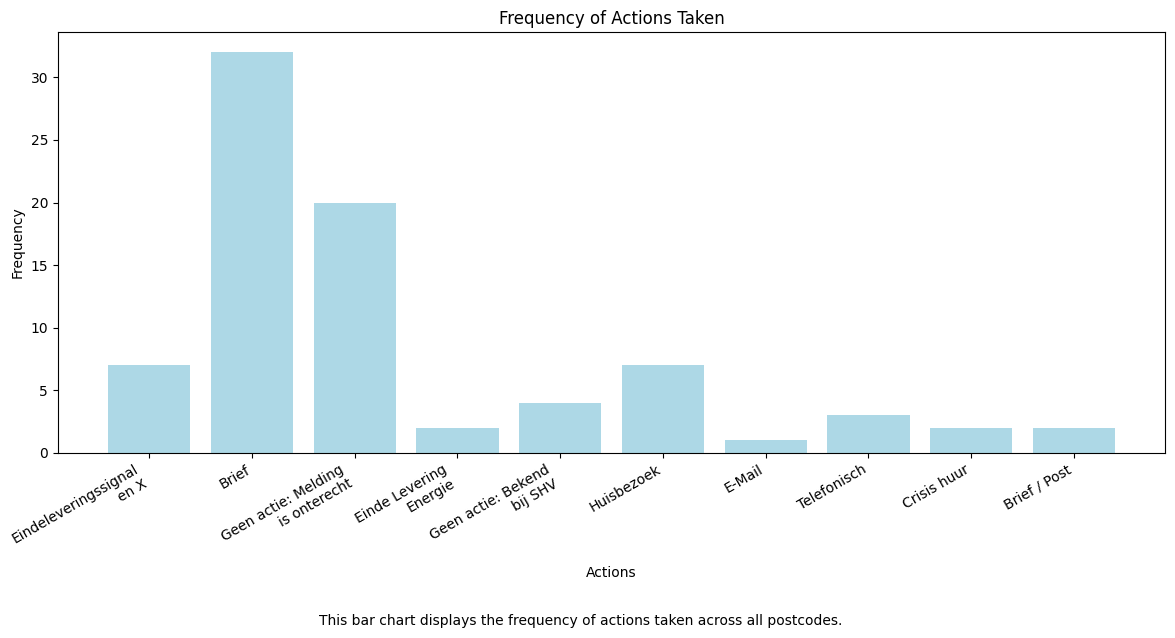

In [5]:
# Profile and print high-risk postcodes
high_risk_threshold = 1000000  # Example threshold
high_risk_postcodes = profile_high_risk_postcodes(matched_debt_summary, high_risk_threshold)
if not high_risk_postcodes.empty:
    print("\nHigh-risk postcode profiles:")
    generate_table_from_results(high_risk_postcodes, postcode_column, 'Total_Debt')


# Plotting actions frequency
plot_actions_frequency(matched_debt_summary)



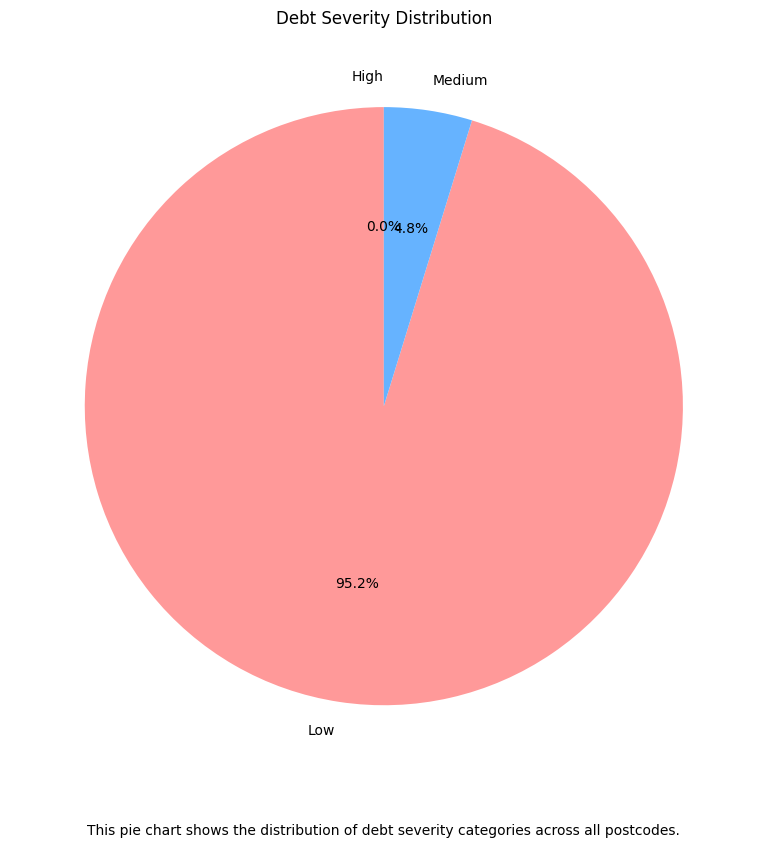

In [6]:
# Plotting debt severity distribution
plot_debt_severity_distribution(matched_debt_summary)

In [7]:
recidive_columns = [
    'RIS Matching: Recidive maand-1',
    'RIS Matching: Recidive maand-2',
    'RIS Matching: Recidive maand-3',
    'RIS Matching: Recidive maand-4',
    'RIS Matching: Recidive maand-5',
    'RIS Matching: Recidive maand-6'
]


# Preprocess Recidive columns
data = preprocess_recidive_columns(data, recidive_columns)

# Analyze Recidive trends
recidive_analysis = analyze_recidive_trends(data)


def display_filtered_recidive_analysis(recidive_analysis):
    """
    Display Recidive Analysis in a concise, filtered table format.
    """
    import pandas as pd
    from IPython.display import display

    # Total Recidive and Average Recidive
    summary_data = {
        "Metric": ["Total Recidive", "Average Recidive Per Month"],
        "Value": [recidive_analysis.get("Total Recidive", 0), recidive_analysis.get("Average Recidive Per Month", 0.0)]
    }
    summary_df = pd.DataFrame(summary_data)

    # Monthly Recidive
    monthly_recidive = recidive_analysis.get("Monthly Recidive", {})
    monthly_recidive_df = pd.DataFrame(list(monthly_recidive.items()), columns=["Month", "Recidive Cases"])

    # Recidive by Postcode: Filter for non-zero cases
    postcode_recidive = recidive_analysis.get("Recidive by Postcode", {})
    postcode_recidive_df = pd.DataFrame(list(postcode_recidive.items()), columns=["Postcode", "Recidive Cases"])
    postcode_recidive_df = postcode_recidive_df[postcode_recidive_df["Recidive Cases"] > 0]

    # Display results
    print("Summary Metrics:")
    display(summary_df)

    print("\nMonthly Recidive:")
    display(monthly_recidive_df)

    if not postcode_recidive_df.empty:
        print("\nFiltered Recidive by Postcode (non-zero cases):")
        display(postcode_recidive_df)
    else:
        print("\nNo recidive cases by postcode.")

display_filtered_recidive_analysis(recidive_analysis)

Summary Metrics:


,Metric,Value
0,Total Recidive,27.0
1,Average Recidive Per Month,4.5



Monthly Recidive:


,Month,Recidive Cases
0,RIS Matching: Recidive maand-1,15.0
1,RIS Matching: Recidive maand-2,5.0
2,RIS Matching: Recidive maand-3,4.0
3,RIS Matching: Recidive maand-4,1.0
4,RIS Matching: Recidive maand-5,1.0
5,RIS Matching: Recidive maand-6,1.0



Filtered Recidive by Postcode (non-zero cases):


,Postcode,Recidive Cases
0,8214,8.0
1,8277,3.0
2,8278,3.0
3,8216,2.0
4,8279,2.0
5,8299,2.0
6,8127,2.0
7,8199,1.0
8,8211,1.0
9,8288,1.0


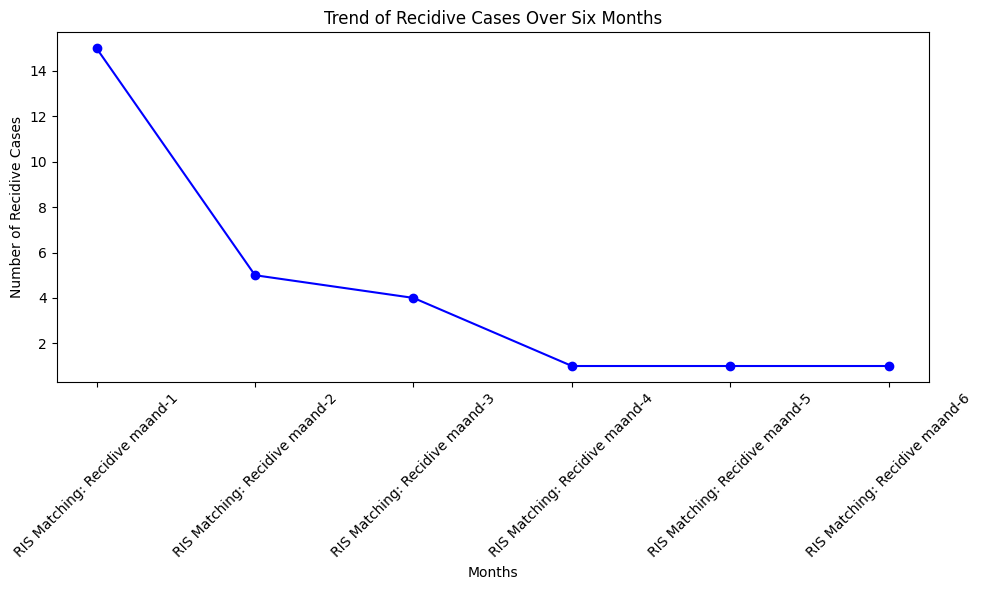

In [9]:
# Plot the trend of Recidive cases
plot_recidive_trend(data)